In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

from prepare_hess_dataset_large_hdf5 import MyDataset

import torch
from torch import Tensor
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel
from torch.nn import Linear 
from torch.nn import BatchNorm1d, Linear, Dropout

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataLoader, DataListLoader
from torch_geometric.nn import TAGConv, global_add_pool, global_max_pool

from pytorch_lightning.core.lightning import LightningModule
from GNN import GNN
from hess_gnn_large_dataset_single_gpu import GCN
from sklearn.metrics import roc_curve, auc
import pandas as  pd
plt.style.use('seaborn-talk')

In [2]:
torch.cuda.empty_cache()

In [3]:
analysis_type = '/hybrid'
phase = '/phase2d3'
models_base_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/trained_models/' + phase + analysis_type
plots_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/plots/' + phase + analysis_type
eval_data_dir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/eval_datasets/' + phase + analysis_type

In [4]:
indir = '/home/woody/caph/mppi067h/gamma_ray_reconstruction_with_ml/gnn/hess_datasets/' + phase + analysis_type
outdir = '/home/saturn/caph/mppi067h/graph_datasets/graph_datasets' + phase + analysis_type
dataset_name = 'test'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
model = GCN(nb_inputs=3, nb_outputs=1).to(device)
best_model_path = models_base_dir + '/model_best.pth'
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

GCN(
  (conv1): TAGConv(3, 128, K=2)
  (conv2): TAGConv(128, 128, K=2)
  (conv3): TAGConv(128, 128, K=2)
  (batchnorm1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=768, out_features=768, bias=True)
  (linear2): Linear(in_features=768, out_features=768, bias=True)
  (linear3): Linear(in_features=768, out_features=768, bias=True)
  (linear4): Linear(in_features=768, out_features=768, bias=True)
  (linear5): Linear(in_features=768, out_features=768, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.3, inplace=False)
  (drop5): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=768, out_features=1, bias=True)
)

In [10]:
dataset = MyDataset(outdir,dataset_name,indir,1)
batch_size = 64

In [11]:
def evaluate_gh_separation(model, dataset, batch_size, device, start_file, end_file):
    correct = 0 
    total_samples = 0
    out_pred_list = list()
    out_label_list = list()
    cr_types = ['gamma','proton']
    for idx in range(start_file,end_file):
        temp_dataset = list()
        for cr_type in cr_types:
            temp_dataset += dataset.get(cr_type,idx)
        temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)
        for bidx, data in enumerate(temp_loader):  # Iterate in batches over the test dataset.
            data = data.to(device)
            out = model(data)
            pred = torch.round(torch.sigmoid(out))
            out_pred_list.append(torch.sigmoid(out).detach()) #we don't wanna round this 
            correct += int((pred == data.y[:,-1].unsqueeze(1)).sum())
            out_label_list.append(data.y.detach())
        total_samples += len(temp_loader.dataset)
    acc = correct/total_samples
    print(f'Acc: {acc:.4f}')
    out_pred = torch.cat(out_pred_list,0).squeeze()
    out_label = torch.cat(out_label_list,0)
    return out_pred, out_label

In [12]:
def plot_classifier(ax, pred, label, name, color):
    ax.hist(pred[label==0], bins=100, histtype='step', lw=2, linestyle='--', color=color);
    ax.hist(pred[label==1], bins=100, label=name, histtype='step', lw=2, linestyle='-', color=color);
    return ax

In [13]:
def plot_roc_curve(ax, pred, label, name):
    fpr, tpr, thresholds = roc_curve(label, pred)
    roc_auc_train = auc(fpr, tpr)
    ax[0].plot(fpr, tpr, label= name + f' AUC = {roc_auc_train:.4f}')
    ax[0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[1].loglog(fpr, tpr)
    ax[1].loglog([0.001, 1], [0.001, 1], color="navy", linestyle="--")
    return ax

In [14]:
file_ini = 0 
file_end = 50
train_val_split = int((file_end - file_ini)*0.8)
file_test = 60

In [15]:
#test
test_pred_temp, test_label_temp = evaluate_gh_separation(model, dataset, batch_size, device, file_end,file_test)
test_pred = test_pred_temp.cpu().detach().numpy()
test_label = test_label_temp[:,-1].cpu().detach().numpy()

Acc: 0.4510


In [13]:
#validation
val_pred_temp, val_label_temp = evaluate_gh_separation(model, dataset, batch_size, device, train_val_split,file_end)
val_pred = val_pred_temp.cpu().detach().numpy()
val_label = val_label_temp[:,-1].cpu().detach().numpy()

Acc: 0.9339


In [14]:
#training
train_pred_temp, train_label_temp = evaluate_gh_separation(model, dataset, batch_size, device, file_ini,train_val_split)
train_pred = train_pred_temp.cpu().detach().numpy()
train_label = train_label_temp[:,-1].cpu().detach().numpy()

Acc: 0.9469


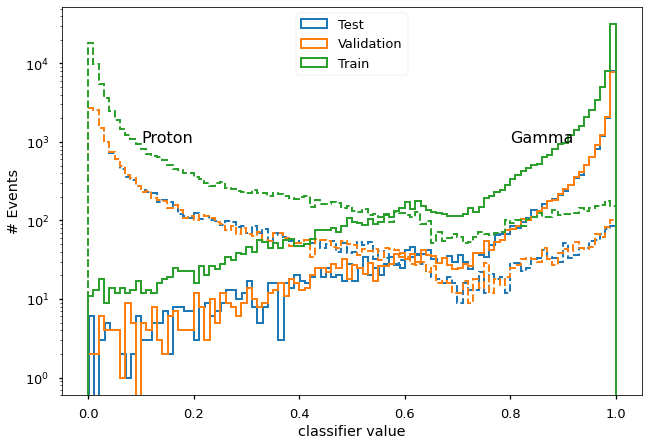

In [15]:
sample_types = {'Test':[test_pred, test_label],
                'Validation':[val_pred, val_label],
                'Train':[train_pred, train_label]}
fig, ax = plt.subplots()
for key in sample_types.keys():  
    color = next(ax._get_lines.prop_cycler)['color']
    ax = plot_classifier(ax, sample_types[key][0], sample_types[key][1], key, color)
ax.set_yscale('log')
ax.set_ylabel('# Events')
ax.set_xlabel('classifier value')
ax.legend(loc='upper center')
ax.text(0.1,1e3,'Proton',fontsize=16)
ax.text(0.8,1e3,'Gamma', fontsize=16)
plt.savefig(plots_dir + '/' + 'classifier_output.pdf',bbox_inches='tight')
plt.savefig(plots_dir + '/' + 'classifier_output.png',bbox_inches='tight')

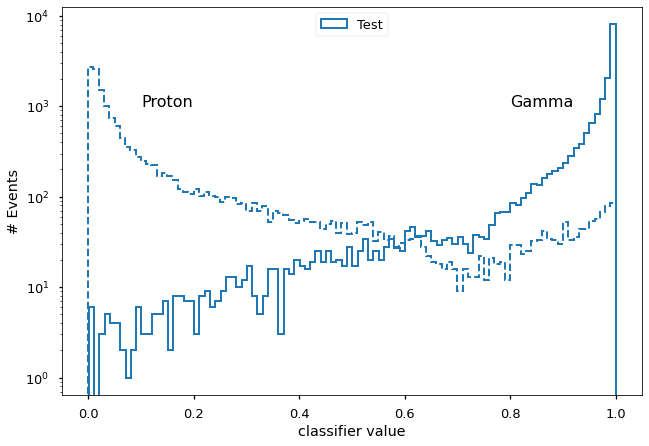

In [16]:
sample_types = {'Test':[test_pred, test_label],}#
                #'Validation':[val_pred, val_label],
                #'Train':[train_pred, train_label]}
fig, ax = plt.subplots()
for key in sample_types.keys():  
    color = next(ax._get_lines.prop_cycler)['color']
    ax = plot_classifier(ax, sample_types[key][0], sample_types[key][1], key, color)
ax.set_yscale('log')
ax.set_ylabel('# Events')
ax.set_xlabel('classifier value')
ax.legend(loc='upper center')
ax.text(0.1,1e3,'Proton',fontsize=16)
ax.text(0.8,1e3,'Gamma', fontsize=16)
plt.savefig(plots_dir + '/' + key + '_classifier_output.pdf',bbox_inches='tight')
plt.savefig(plots_dir + '/' + key + '_classifier_output.png',bbox_inches='tight')

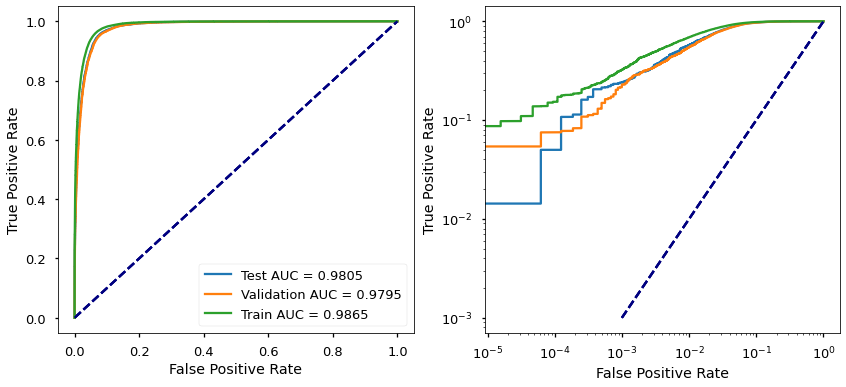

In [17]:
sample_types = {'Test':[test_pred, test_label],
                'Validation':[val_pred, val_label],
                'Train':[train_pred, train_label]}
fig, ax = plt.subplots(1,2, figsize=(14,6))
for key in sample_types.keys():  
    ax = plot_roc_curve(ax, sample_types[key][0], sample_types[key][1], key)
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend(loc="lower right")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
plt.savefig(plots_dir+'/roc_curve.pdf',bbox_inches='tight')
plt.savefig(plots_dir+'/roc_curve.png',bbox_inches='tight')

#### save the evaluted datasets

In [18]:
col_names = ['tel_count', 'is_ct5','obs_id', 'event_id', 'true_energy', 'true_alt', 'true_az', 'true_core_x', 'true_core_y', 
             'true_h_first_int', 'true_x_max', 'true_shower_primary_id', 'score']

In [19]:
test_final = torch.cat((test_label_temp, test_pred_temp.unsqueeze(1)), 1)
test_final = pd.DataFrame(test_final.cpu().detach().numpy(), columns=col_names)
val_final = torch.cat((val_label_temp, val_pred_temp.unsqueeze(1)), 1)
val_final = pd.DataFrame(val_final.cpu().detach().numpy(), columns=col_names)
train_final = torch.cat((train_label_temp, train_pred_temp.unsqueeze(1)), 1)
train_final = pd.DataFrame(train_final.cpu().detach().numpy(), columns=col_names)

In [20]:
pd.to_pickle(test_final, eval_data_dir + "/test_final.pkl")
pd.to_pickle(val_final, eval_data_dir + "/val_final.pkl")
pd.to_pickle(train_final, eval_data_dir + "/train_final.pkl")